Digit recognition is not something that difficult or advanced. It is kind of "Hello world!" program - not that cool, but you start exactly here. So I decided to share my work and at the same time refresh the knowledge - it's being a long ago I played with images.

---

We start with importing all the necessary packages.

In [0]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

MNIST dataset, which contains 20 thousand hand-written digits is a "Hello World" dataset for this task, it is already preloaded in Colaboratory (cloud-based Python notebooks, fantastic thing), so we will use it. No need to invent a wheel here. 

In [2]:
# load data
df = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
len(df)

20000

As we can see from the head() method, first column in dataset contains labels and the rest pixels of the image 28x28 - that is why we have 784 columns more. 
It is also useful to check the length of the dataset each time after some modification to make sure we did everything correct.

---

Next, let's visualize our pixels and watch the images we have. We use randint() to select random image every time we run the code below. Also we have to transform our pixels to numpy array (now its' type is Series) and reshape it to the size 28x28 to be able to plot them.

label: 9


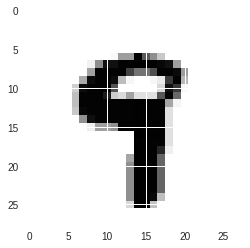

In [4]:
ix = random.randint(0, len(df)-1)
label, pixels = df.loc[ix][0], df.loc[ix][1:]
img = np.array(pixels).reshape((28,28))
print('label: ' + str(label))
plt.imshow(img)

Now, to make our life little bit easier we will transform our dataframe to have only two columns - label and image, where image is a numpy array of pixels. Also we will reduce the size of dataframe for faster computation (first we want to make sure everything works and then we start playing with model)

In [5]:
# transforming df for easier manipulation
labels, imgs = [], []
for index, row in df.iterrows():
    label, pixels = row[0], row[1:]
    img = np.array(pixels)
    labels.append(label)
    imgs.append(img)
df2 = pd.DataFrame({'label': labels, 'img': imgs})
df2 = df2[:1000]
df2.head()

,img,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


label: 9


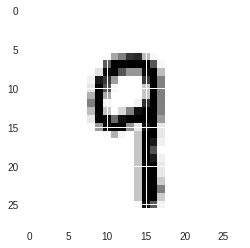

In [6]:
# checking images using new df structure
ix = random.randint(0, len(df2)-1)
img = df2.loc[ix].img.reshape((28,28))
label = df2.loc[ix].label
print('label: ' + str(label))
plt.imshow(img)

When we have our data prepared, we want to split it into 2 datasets: one to traing our model and another to test it's performance. And the best way to do that is using *sklearn*. We set up a *test_size=0.2* which is standard value for this operation (usually for test we leave 20-30% of data), which means that for training remains 80%. It is also a good practice to set *shuffle=True* as some datasets might have ordered data, so the model will learn to recognize 0s and 1s, but won't have any idea that 8 exists for example.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df2, test_size=0.2, shuffle=True)

print(len(train_df), len(test_df))

800 200


In [8]:
train_df.head()

,img,label
825,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
305,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
189,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
397,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
70,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8


We check the length, the head of datasets - all good, we can start building our model. For this we will need to install *pytorch*. If we go to "Code snippets" and start typing there *'pyt'* it will show us "Install [pytorch]", so we can insert it into our notebook.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [10]:
# importing torch and setting up the device
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Next, we have to transform our data into pytorch Dataset. `torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:
*   `__len__ `so that `len(dataset)` returns the size of the dataset.
*   `__getitem__` to support the indexing such that `dataset[i]` can be used to get its sample



In [0]:
# create torch dataset
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
  def __init__(self, imgs, labels):
    super(MNISTDataset, self).__init__()
    self.imgs = imgs
    self.labels = labels
    
  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, ix):
    img = self.imgs[ix]
    label = self.labels[ix]
    return torch.from_numpy(img).float(), label

In [12]:
dataset = {
    'train': MNISTDataset(train_df.img.values, train_df.label.values),
    'test': MNISTDataset(test_df.img.values, test_df.label.values)
} 

len(dataset['train'])

800

torch.Size([784]) torch.float32
6


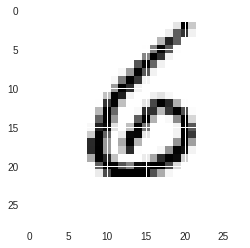

In [13]:
# againg checking image, now based on torch dataset
ix = random.randint(0, len(dataset['train'])-1)
img, label = dataset['train'][ix]
print(img.shape, img.dtype)
print(label)
plt.imshow(img.reshape((28,28)))

The beauty of pytorch is its simplicity in defining the model. We define our layer with inputs and outputs, we add some batch normalization to improve our model (It is a technique to provide any layer in a neural network with inputs that are zero mean/unit variance) and activation function, in this case ReLU.

For the first input we have 784 neurons (one neuron per each pixel) and 512 for output (this one is almost random - I tried few different values and this one performed pretty well, so I left it). Next layer will have 512 inputs (input_layer[n+1] == output_layer[n]) and 256 for output, next 256 inputs and 128 outputs and the last one - 128 inputs and 10 for output (each neuron represents one of 10 digits)

In [14]:
# create model
import torch.nn as nn

def block(in_f, out_f):
  return nn.Sequential(
      nn.Linear(in_f, out_f),
      nn.BatchNorm1d(out_f),
      nn.ReLU(inplace=True),
      #nn.Dropout(),
  )

model = nn.Sequential(
  block(784,512),
  block(512,256),
  block(256,128),
  nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): Linear(in_features=128, out_features=10, bias=True)
)

Now we need to create few additional parameters for our model:

*   criterion - to calculate loss function, in our case [CrossEntropyLoss](https://https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
*   optimizer - to set up learning rate
*   scheduler - to update learning rate if model doesn't improve with time (quite powerful technique, allows us to tweak the system on the go)
*   dataloader - class for pytorch that provides single- or multi-process iterators over the dataset



In [0]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=3, min_lr=0.0001, verbose=True)

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(dataset['test'], batch_size=32, shuffle=False, num_workers=4),
}

With all above we can start training and evaluating our model. Although we define 100 epochs, it is also useful to stop the loop if model doesn't improve with time. Here we have set up `early_stop = 10`, so if model doesn't change for 10 epochs in a row we will stop the training process.

Training process: we iterate through our train data by assigning each image and label to a device defined previously, we give our model an image and it tries to find the correct class (`preds`), we clear all gradients (`zero_grad()`) and calculate the loss function and the gradient (`loss`), perform an optimizer step and append new value to a `total_loss` array.

Testing process: we iterate through the test data, make predictions, calculate the loss and accuracy of the model. In `torch.max()` we are looking for an index of the maximum value as it will represent the class of a digit and in our case it will match labels. Then by comparing labels and predictions we calculate the accuracy of our model.

Every time we find the best model we save it and if we hit the `early_stop` we exit and report the results. Usually it won't need all those 100 epochs.

In [16]:
# train
best_acc, stop, early_stop = 0, 0, 10
for e in range(100):
    
  model.train()
  total_loss = []
  for imgs, labels in tqdm(dataloader['train']):
    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    optimizer.zero_grad()
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.data)
    
  model.eval()
  val_loss, acc = [], 0.
  with torch.no_grad():
    for imgs, labels in tqdm(dataloader['test']):
      imgs, labels = imgs.to(device), labels.to(device)
      preds = model(imgs)
      loss = criterion(preds, labels)
      val_loss.append(loss.data)
      _, preds = torch.max(preds, 1)
      acc += (preds == labels).sum().item()
      
  acc /= len(dataset['test'])
  if acc > best_acc:
    print('\n Best model ! saved.')
    torch.save(model.state_dict(), 'best_model.pt')
    best_acc = acc
    stop = -1
  
  stop += 1
  if stop >= early_stop:
    break
    
  scheduler.step(acc)
    
  print('\n Epoch {}, Training loss: {:4f}, Val loss: {:4f}, Val acc: {:4f}'.format(
      e+1, np.array(total_loss).mean(), np.array(val_loss).mean(), acc))
  
print('\n Best model with acc: {}'.format(best_acc))

  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 1, Training loss: 1.287729, Val loss: 1.297057, Val acc: 0.690000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 2, Training loss: 0.714153, Val loss: 1.025788, Val acc: 0.770000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 3, Training loss: 0.526018, Val loss: 0.475901, Val acc: 0.855000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 4, Training loss: 0.390981, Val loss: 0.584928, Val acc: 0.850000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 5, Training loss: 0.299076, Val loss: 0.409660, Val acc: 0.890000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 6, Training loss: 0.282667, Val loss: 0.569010, Val acc: 0.890000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 7, Training loss: 0.368993, Val loss: 0.546251, Val acc: 0.870000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 8, Training loss: 0.293367, Val loss: 0.588393, Val acc: 0.830000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 9, Training loss: 0.176275, Val loss: 0.452349, Val acc: 0.895000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 10, Training loss: 0.190740, Val loss: 0.749223, Val acc: 0.855000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 11, Training loss: 0.231334, Val loss: 0.710024, Val acc: 0.845000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 12, Training loss: 0.176967, Val loss: 0.570731, Val acc: 0.840000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.0000e-02.

 Epoch 13, Training loss: 0.195777, Val loss: 0.656643, Val acc: 0.865000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 14, Training loss: 0.085389, Val loss: 0.498354, Val acc: 0.875000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 15, Training loss: 0.031412, Val loss: 0.436563, Val acc: 0.890000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 16, Training loss: 0.029874, Val loss: 0.388386, Val acc: 0.900000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 17, Training loss: 0.049520, Val loss: 0.423354, Val acc: 0.900000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 18, Training loss: 0.023294, Val loss: 0.386265, Val acc: 0.900000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 19, Training loss: 0.022117, Val loss: 0.393941, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 20, Training loss: 0.023545, Val loss: 0.388233, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 21, Training loss: 0.005979, Val loss: 0.374836, Val acc: 0.910000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 22, Training loss: 0.013613, Val loss: 0.374461, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 23, Training loss: 0.005479, Val loss: 0.358950, Val acc: 0.895000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 24, Training loss: 0.015302, Val loss: 0.384199, Val acc: 0.910000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 1.0000e-03.

 Epoch 25, Training loss: 0.002659, Val loss: 0.428535, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 26, Training loss: 0.007188, Val loss: 0.429362, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 27, Training loss: 0.023056, Val loss: 0.421917, Val acc: 0.905000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 28, Training loss: 0.011646, Val loss: 0.442238, Val acc: 0.910000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.

 Epoch 29, Training loss: 0.010954, Val loss: 0.404354, Val acc: 0.910000


  0%|          | 0/25 [00:00<?, ?it/s]


 Epoch 30, Training loss: 0.015759, Val loss: 0.397337, Val acc: 0.910000


100%|██████████| 7/7 [00:00<00:00, 73.41it/s]


 Best model with acc: 0.91


When we find our best model and save it, we can play with it by feeding it with new data and see how it performs.

Ground Truth: 5, Prediction: 5


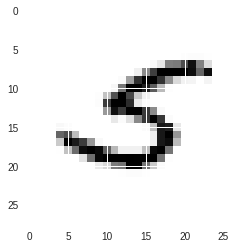

In [17]:
# test
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

ix = random.randint(0, len(dataset['test'])-1)
img, label = dataset['test'][ix]
pred = model(img.unsqueeze(0).to(device)).cpu()
pred_label = torch.argmax(pred)
print('Ground Truth: {}, Prediction: {}'.format(label, pred_label))
plt.imshow(img.reshape((28,28)))

Like it was said in the beginning it is a "Hello World" for the image recognition, we didn't use convolutional neural network which is normally used in tasks like this, just entry level to understand the flow. I don't usually work with images, so if there are some mistakes, please let me know. It was a nice refresher for me, hopefully it helped someone else.